In [57]:
from vedo import Mesh, Box, Sphere, ConvexHull
import numpy as np
# import matplotlib as plt
import matplotlib.pyplot as plt
from normalize import get_eigenvectors, normalize_shape, get_center_of_mass
import os
import pandas as pd
from glob import glob


In [51]:
boxMesh = normalize_shape(Box(width=1,height=1,length=1).c("Black").wireframe(True))
sphereMesh = normalize_shape(Sphere(r=1, res=24, quads=False, c='red', alpha=1.0))
train = normalize_shape(Mesh("../shapes/Train/D01014.obj"))
head = normalize_shape(Mesh("../shapes/HumanHead/D00131.obj"))
insect = normalize_shape(Mesh("../shapes/Insect/D00117.obj"))

door1 = normalize_shape(Mesh("../shapes/Door/D01177.obj"))
door2 = normalize_shape(Mesh("../shapes/Door/D01141.obj"))
humanoid = normalize_shape(Mesh("../shapes/Humanoid/m155.obj"))
bycicle = normalize_shape(Mesh("../shapes/Bicycle/D00567.obj"))



Box: {'area': 5.999999999999999, 'volume': 0.9999999999999998, 'rectangularity': 0.9999999999999998, 'compactness': 1.9098593171027443, 'convexity': 0.9999999999999999, 'eccentricity': 1.0, 'diameter': 1.7320508, 'diameterPts': [array([-0.5, -0.5,  0.5], dtype=float32), array([ 0.5,  0.5, -0.5], dtype=float32)], 'distributions': {'A3': array([0.04825901, 0.12013846, 0.16330686, 0.18489106, 0.16330686,
       0.12278558, 0.09061291, 0.05110975, 0.03034005, 0.01282834,
       0.0091631 , 0.00325799]), 'D1': array([0.0978, 0.1082, 0.108 , 0.1096, 0.1224, 0.1296, 0.1298, 0.0752,
       0.0564, 0.0346, 0.02  , 0.0084]), 'D2': array([0.01730104, 0.03114187, 0.04844291, 0.07958478, 0.08650519,
       0.09688581, 0.11418685, 0.21799308, 0.12456747, 0.12802768,
       0.03460208, 0.02076125]), 'D3': array([0.00549562, 0.01485854, 0.03806228, 0.07001832, 0.10604519,
       0.13962955, 0.1579483 , 0.17097496, 0.15611643, 0.10136373,
       0.03561978, 0.00386729]), 'D4': array([0.01170508, 0.0283

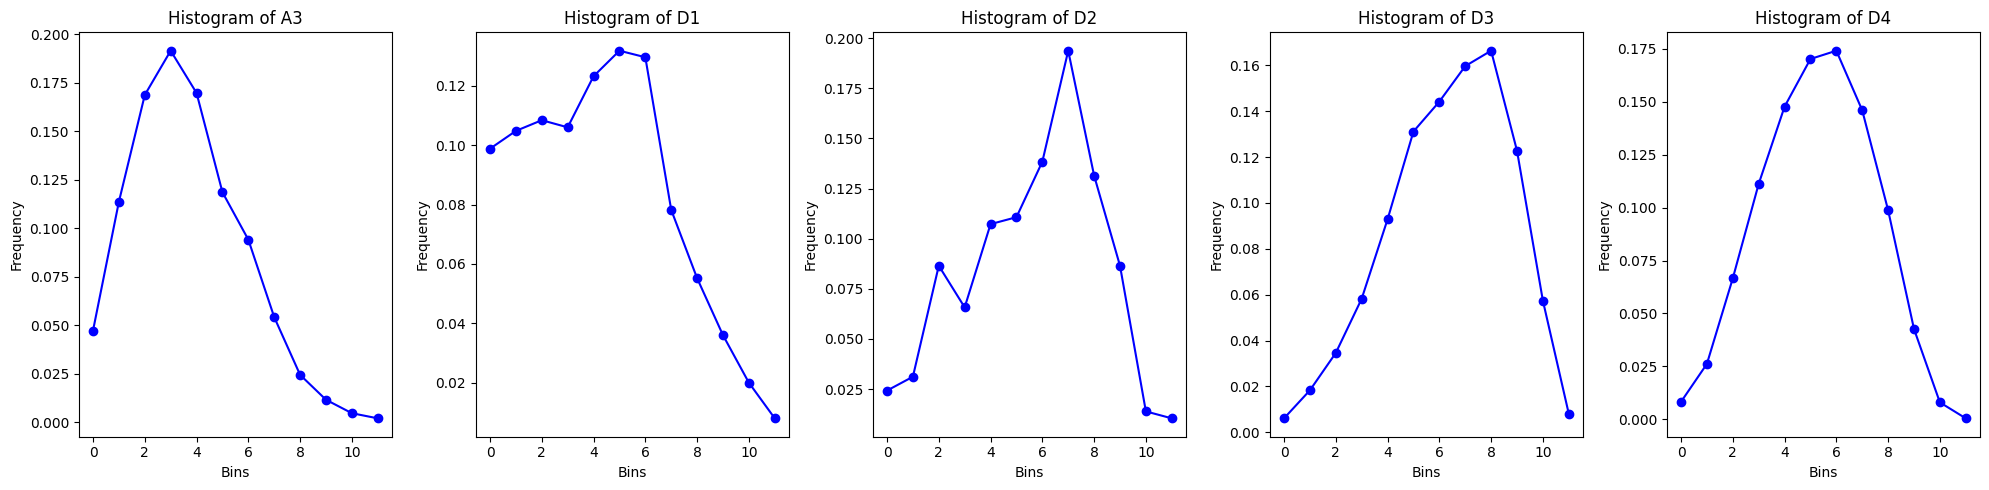

In [76]:
def extract_features(mesh:Mesh):
    cvx = ConvexHull(mesh.vertices)
    diameterRet = get_diameter(mesh,cvx)
    mesh.fill_holes()
    mesh.triangulate()
    ret = {
        "area":mesh.area(),
        "volume":mesh.volume(),
        "rectangularity":get_rectangularity(mesh),
        "compactness":get_compactness(mesh),
        "convexity": get_convexity(mesh,cvx),
        "eccentricity":get_eccentricity(mesh),
        "diameter":diameterRet[0],
        "diameterPts":diameterRet[1],
        "distributions":get_distributions(mesh)
    }
    return ret

import numpy as np

# subsampling vertices using smart subsampling
def subsample_vertices(vertices, num_samples = 5000, num_vertices=3):
    N = len(vertices)  
    k = int(np.cbrt(num_samples)) 

    sampled_groups = []

    for i in range(k):
        vi = np.random.randint(0, N)  
        for j in range(k):
            vj = np.random.randint(0, N)
            if vj == vi:
                continue  
            if num_vertices == 2:
                sampled_groups.append((vertices[vi], vertices[vj]))
                continue

            for l in range(k):
                vl = np.random.randint(0, N)
                if vl == vi or vl == vj:
                    continue  
                if num_vertices == 3:
                    sampled_groups.append((vertices[vi], vertices[vj], vertices[vl]))
                    continue
                for m in range(k):
                    vm = np.random.randint(0, N)
                    if vm == vi or vm == vj or vm == vl:
                        continue  
                    if num_vertices == 4:
                        sampled_groups.append((vertices[vi], vertices[vj], vertices[vl], vertices[vm]))

    return sampled_groups

def get_surface_area(mesh:Mesh):
    #area = sqrt(fabs(s * (s - a) * (s - b) * (s - c)));
    return mesh.area()

def get_rectangularity(mesh:Mesh):
    #How close is the shape (post normalisation to its oriented bounding box)
    # (shape volume divided by OBB volume)
    bbox = mesh.bounds()
    Dx = np.abs(bbox[0] - bbox[1])  
    Dy = np.abs(bbox[2] - bbox[3])  
    Dz = np.abs(bbox[4] - bbox[5])  
    obbVol = Dx*Dy*Dz
    rectangularity = mesh.volume()/obbVol
    return rectangularity

def get_compactness(mesh:Mesh):
    #How close is the shape to a sphere
    return mesh.area()**3/(36*np.pi*(mesh.volume()**2))

def get_convexity(mesh:Mesh,cvx:ConvexHull):
    #(shape volume divided by convex hull volume)
    convexity = mesh.volume()/cvx.volume()
    return convexity


def get_diameter(mesh:Mesh,cvx:ConvexHull,k=500):
    maxD = 0
    maxP = [None,None]
    if(len(cvx.vertices)<k):
        subs=cvx.vertices
    else:
        subs = cvx.vertices[np.random.choice(cvx.vertices.shape[0], k, replace=False)]
    for v1 in subs:
        for v2 in cvx.vertices:
            d = np.linalg.norm(v1-v2)
            if d>maxD:
                maxD=d
                maxP = [v1,v2]
    return maxD,maxP        
        
        

def get_eccentricity(mesh:Mesh):
    #ratio of largest to smallest eigenvalues of covariance matrix
    _,eigval = get_eigenvectors(mesh)
    mineig = min(eigval)
    maxeig = max(eigval)
    return np.abs(maxeig)/np.abs(mineig)

def get_angle_between_vectors(v1, v2):
    #angle between two vectors 
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_angle, -1.0, 1.0))  

def get_hist(desc_vals, bins=10, normalize=True):
    hist, bin_edges = np.histogram(desc_vals, bins=bins, density = False) 
    if normalize:
        hist = hist / np.sum(hist) 
    
    # bin_edges = (bin_edges - np.min(bin_edges)) / (np.max(bin_edges) - np.min(bin_edges))

    return hist
# , bin_edges[:-1] 

def get_distributions(mesh:Mesh, show=True):
    num_samples = 5000
    bins = 12

    A3_vals = calc_A3(mesh, num_samples)
    D1_vals = calc_D1(mesh, num_samples)
    D2_vals = calc_D2(mesh, num_samples)
    D3_vals = calc_D3(mesh, num_samples) 
    D4_vals = calc_D4(mesh, num_samples)

    A3_hist = get_hist(A3_vals, bins)
    D1_hist = get_hist(D1_vals, bins)
    D2_hist = get_hist(D2_vals, bins)   
    D3_hist = get_hist(D3_vals, bins)
    D4_hist = get_hist(D4_vals, bins)

    distributions = {
        "A3":A3_hist,
        "D1":D1_hist,
        "D2":D2_hist, 
        "D3":D3_hist,
        "D4":D4_hist,

    }
    return distributions

def plot_hist(distributions):
    descriptor_names = distributions.keys()  #names
    
    #all histograms here
    fig, axs = plt.subplots(1, len(descriptor_names), figsize=(20, 5))

    # Plot each histogram
    for i, name in enumerate(descriptor_names):
        # hist, bin_centers = distributions[name]
        data = distributions[name]
        #axs[i].bar(range(len(distributions[name])), distributions[name])
        axs[i].plot(range(len(data)), data, marker='o', linestyle='-', color='b')  # Use line chart with markers
        axs[i].set_title(f"Histogram of {name}")
        axs[i].set_xlabel("Bins")
        axs[i].set_ylabel("Frequency")
        # axs[i].set_ylim([0, 1])  
        # axs[i].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()

#Calculate distance between the center and a random subset, returns list of euclidian distances
# for D1 max num samples = nr of vertices
def calc_D1(mesh: Mesh, num_samples = 500):

    actual_num_vertices = mesh.vertices.shape[0]
    center = get_center_of_mass(mesh)
    nr_samples = min(num_samples, actual_num_vertices)
    subsample = mesh.vertices[np.random.choice(mesh.vertices.shape[0], nr_samples, replace=False), :]
   
    ret = []
    # for pt in subs:
    for pt in subsample:
        ret.append(np.linalg.norm(pt - center))
    return ret

# max num samples  = (nr of vertices)^3
def calc_A3(mesh: Mesh, num_samples = 500):
    # A3 for x(num_samples) number of times for each shape 
    angles = []
    vertices = mesh.vertices
    sampled_triples = subsample_vertices(vertices, num_samples, num_vertices=3) 
    # for _ in range(num_samples):
    #     v1, v2, v3 = vertices[np.random.choice(len(vertices), 3, replace=False)]
    for triple in sampled_triples:
        v1, v2, v3 = triple
        vec1 = v2 - v1
        vec2 = v3 - v1
        angle = get_angle_between_vectors(vec1, vec2)
        angles.append(angle)
    return np.array(angles)

# max num samples  = (nr of vertices) ^ 2
def calc_D2(mesh: Mesh, num_samples=500):
    # D2 for x number of times, return concatenated val
    distances = []
    vertices = mesh.vertices
    sampled_duples = subsample_vertices(vertices, num_samples, num_vertices = 2)
    # for _ in range(num_samples):
    #     v1, v2 = vertices[np.random.choice(len(vertices), 2, replace=False)]
    for duple in sampled_duples:
        v1, v2 = duple
        distance = np.linalg.norm(v1 - v2)
        distances.append(distance)
    return np.array(distances)

# max num samples  = (nr of vertices)^3
def calc_D3(mesh: Mesh, num_samples = 500):
    areas = []
    vertices = mesh.vertices
    sampled_triples = subsample_vertices(vertices, num_samples, num_vertices=3) 
    # for _ in range(num_samples):
    #     v1, v2, v3 = vertices[np.random.choice(len(vertices), 3, replace=False)]
    for triple in sampled_triples:
        v1, v2, v3 = triple
        area = 0.5 * np.linalg.norm(np.cross(v2 - v1, v3 - v1))
        areas.append(np.sqrt(area))
    return np.array(areas)

# max num samples  = (nr of vertices)^4
def calc_D4(mesh: Mesh, num_samples = 500):
    volumes = []
    vertices = mesh.vertices
    sampled_quadruples = subsample_vertices(vertices, num_samples, num_vertices = 4)
    # for _ in range(num_samples):
    #     v1, v2, v3, v4 = vertices[np.random.choice(len(vertices), 4, replace=False)]
    for q in sampled_quadruples:
        v1, v2, v3, v4 = q
        # volume of tetrahedron
        volume = np.abs(np.dot((v4 - v1), np.cross(v2 - v1, v3 - v1))) / 6
        volumes.append(np.cbrt(volume))
    return np.array(volumes)

box_features = extract_features(boxMesh)

print("Box:",extract_features(boxMesh))
print("Sphere:",extract_features(sphereMesh))
print("Train:",extract_features(train))
print("Head:",extract_features(head))
print("Insect:",extract_features(insect))

plot_hist(box_features['distributions'])

    

Comparing 2 meshes from the same class and one from a different one: can see that the Histograms are similar for all features for the first 2 meshes and different for the last one.

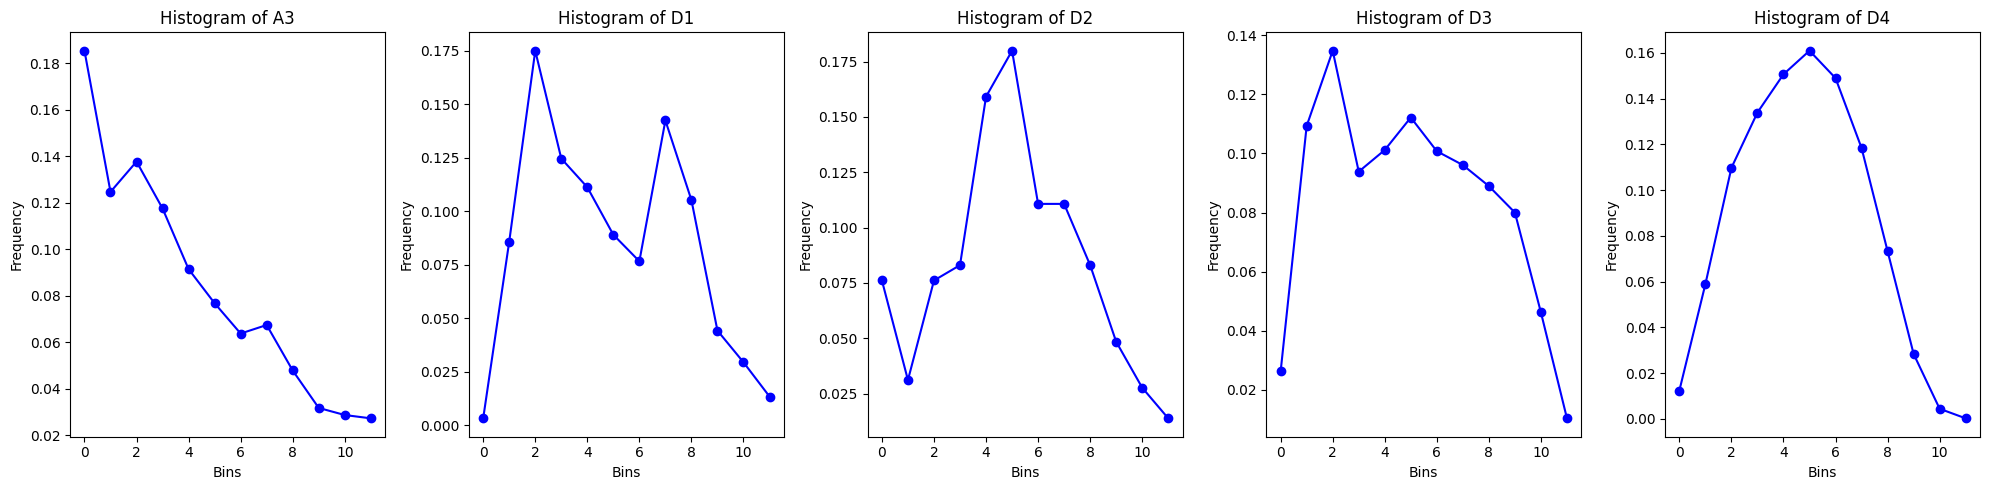

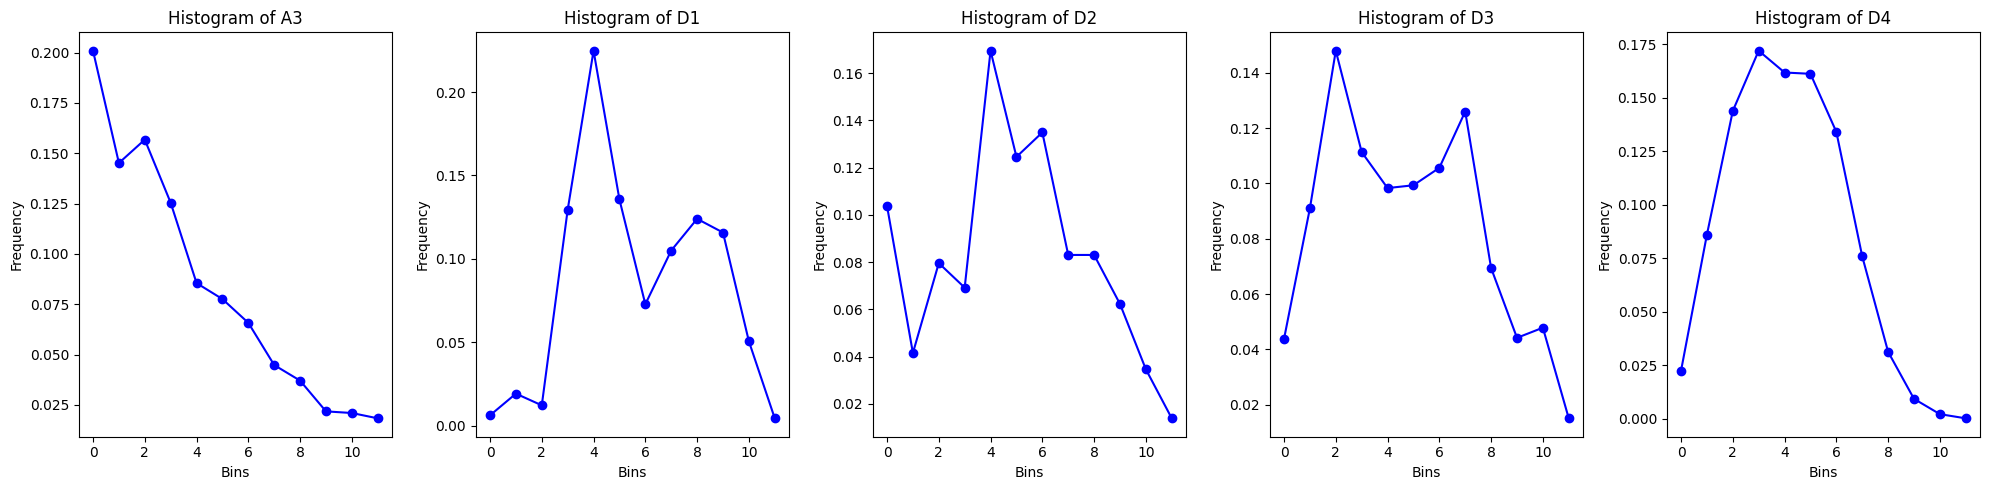

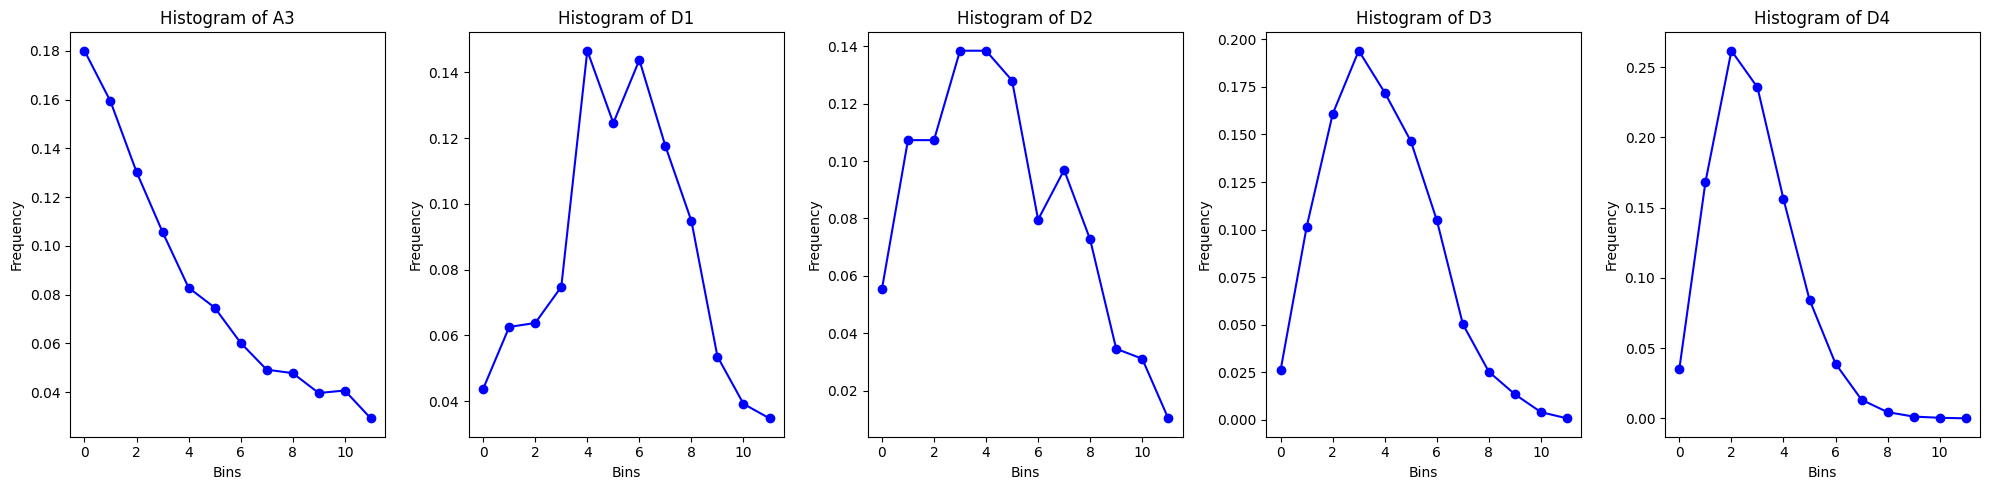

In [78]:
door1_features = extract_features(door1)
door2_features = extract_features(door2)
insect_features = extract_features(insect)
humanoid_features = extract_features(humanoid)
bycicle_features = extract_features(bycicle)

plot_hist(door1_features['distributions'])
plot_hist(door2_features['distributions'])
plot_hist(bycicle_features['distributions'])

Difficult Calculations
Area - Positive vs Negative (RIght hand rule, counterclockwise orientation = positive, thumb away from screen)
    Solution 1) Ignore sign -> Problem Concave Shapes have "negative" areas -> Areas are overstimated
    Same applies for volume
    Solution 2) Incooperate Sign -> Allow negative areas, concavities are incooperated. Problem: consistent orientation along boundary
    FOr VOlumes check orientation of triangles. -> Get Consistently oriented triangles.

HOle Filling:
Every Edge is shared by two triangles. If an edge has a single edge -> it is a boundary. If you have a boundary loop -> fill. 


In [9]:
print(len(head.vertices))
chull = ConvexHull(head.vertices)
print(len(chull.vertices))

5161
1809


Saving features for each mesh in a csv file , so working with the entire dataset

In [79]:
def extract_dataset_features_from_shapes(shape_directory="shapes", output_file="all_mesh_features.csv"):
   
    feature_data = []

    for class_name in os.listdir(shape_directory):
        class_path = os.path.join(shape_directory, class_name)
        
        if os.path.isdir(class_path):
           
            mesh_files = glob(os.path.join(class_path, '*.obj'))
            
            for mesh_file in mesh_files:
                mesh = normalize_shape(Mesh(mesh_file))
                features = extract_features(mesh)

                feature_row = {
                    "mesh_name": os.path.basename(mesh_file),  
                    "class": class_name,                        
                    "area": features["area"],
                    "volume": features["volume"],
                    "rectangularity": features["rectangularity"],
                    "compactness": features["compactness"],
                    "convexity": features["convexity"],
                    "eccentricity": features["eccentricity"],
                    "diameter": features["diameter"]
                }
                
                #add histogram distributions
                for dist_name, dist_values in features["distributions"].items():
                    for bin_idx, bin_value in enumerate(dist_values):
                        feature_row[f"{dist_name}_bin_{bin_idx}"] = bin_value
                
                feature_data.append(feature_row)
    

    feature_df = pd.DataFrame(feature_data)
    

    target_directory = os.getcwd()  

    output_path = os.path.join(target_directory, output_file)
    feature_df.to_csv(output_path, index=False)
    print(f"Feature extraction complete. Features saved to {output_path}.")


extract_dataset_features_from_shapes(shape_directory="/Users/ralucastanescu/Desktop/INFOMR/INFOMR-final-project/shapes", output_file="all_mesh_features.csv")


/var/folders/4d/ntyf354s19739_77yyhpww0h0000gn/T/ipykernel_76098/1101465191.py:105: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


ValueError: autodetected range of [nan, nan] is not finite